# phase 1

## imports

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torchvision
# import utils
from typing import List
from torchvision import transforms, models, datasets
import torch
from torchinfo import summary
from torch.utils.data import DataLoader, Subset, random_split, ConcatDataset
import numpy as np
import random
from os.path import exists
import os
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, confusion_matrix

## GPU state

In [3]:
use_gpu = True
device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")
# device = torch.device("cpu")
device

device(type='cuda', index=0)

In [4]:
import torch

# Check if CUDA (GPU support) is available
print("CUDA available: ", torch.cuda.is_available())

# Check if code is running on GPU
print("Code running on GPU: ", torch.cuda.is_initialized())


CUDA available:  True
Code running on GPU:  False


## Data Loader

In [5]:
def get_oxford_splits(
    batch_size: int,
    data_loader_seed: int = 111,
    pin_memory: bool = True,
    num_workers: int = 2,
    ):
    K = 5
    num_support = 80
    num_query = 20

    def seed_worker(worker_id):
        # worker_seed = torch.initial_seed() % 2 ** 32
        np.random.seed(data_loader_seed)
        random.seed(data_loader_seed)
    g = torch.Generator()
    g.manual_seed(data_loader_seed)

    support_classes = list(np.arange(num_support))
    query_classes = list(np.arange(num_query) + num_support)

    img_dim = 64

    train_transforms = transforms.Compose([
        transforms.Resize((img_dim, img_dim)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
    test_transforms = transforms.Compose([
        transforms.Resize((img_dim, img_dim)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
    validation_transforms = transforms.Compose([
        transforms.Resize((img_dim, img_dim)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

    data_path = f'/content/data'

    train_ds_full = datasets.Flowers102(root=data_path, split="train", download=True, transform=train_transforms)
    val_ds_full = datasets.Flowers102(root=data_path, split="val", download=True, transform=validation_transforms)
    test_ds_full = datasets.Flowers102(root=data_path, split="test", download=True, transform=test_transforms)

    train_indxs_support = torch.where(torch.isin(torch.tensor(train_ds_full._labels), torch.asarray(support_classes)))[0]
    val_indxs_support = torch.where(torch.isin(torch.tensor(val_ds_full._labels), torch.asarray(support_classes)))[0]
    test_indxs_support = torch.where(torch.isin(torch.tensor(test_ds_full._labels), torch.asarray(support_classes)))[0]

    train_ds_subset_support = torch.utils.data.Subset(train_ds_full, train_indxs_support)
    val_ds_subset_support = torch.utils.data.Subset(val_ds_full, val_indxs_support)
    test_ds_subset_support = torch.utils.data.Subset(test_ds_full, test_indxs_support)

    merged_dataset = ConcatDataset([train_ds_subset_support, val_ds_subset_support, test_ds_subset_support])
    ### A, B
    train_ds_support, test_ds_support = torch.utils.data.random_split(merged_dataset, [0.75, 0.25], generator=torch.Generator().manual_seed(42))
    ###

    train_indxs_query = torch.where(torch.isin(torch.tensor(train_ds_full._labels), torch.asarray(query_classes)))[0]
    N = 10
    starting_indices = np.arange(0, len(train_indxs_query), N)
    train_indxs_query = np.hstack([train_indxs_query[i:i+K] for i in starting_indices if i + K <= len(train_indxs_query)])
    ### C
    train_ds_query = torch.utils.data.Subset(train_ds_full, train_indxs_query)
    ###

    val_indxs_query = torch.where(torch.isin(torch.tensor(val_ds_full._labels), torch.asarray(query_classes)))[0]
    test_indxs_query = torch.where(torch.isin(torch.tensor(test_ds_full._labels), torch.asarray(query_classes)))[0]
    val_ds_subset_query = torch.utils.data.Subset(val_ds_full, val_indxs_query)
    test_ds_subset_query = torch.utils.data.Subset(test_ds_full, test_indxs_query)

    test_ds_query_full = ConcatDataset([val_ds_subset_query, test_ds_subset_query])
    ### D
    _, test_ds_query = torch.utils.data.random_split(test_ds_query_full, [0.7, 0.3], generator=torch.Generator().manual_seed(42))
    ###

    ### E
    test_all = ConcatDataset([test_ds_query, test_ds_support])


    A_train_dl = DataLoader(
        train_ds_support,
        batch_size = batch_size,
        shuffle=True,
        worker_init_fn=seed_worker,
        generator=g,
        drop_last=False,
        pin_memory=pin_memory,
        num_workers=num_workers
    )
    A_test_dl = DataLoader(
        test_ds_support,
        batch_size = batch_size,
        shuffle=True,
        worker_init_fn=seed_worker,
        generator=g,
        drop_last=False,
        pin_memory=pin_memory,
        num_workers=num_workers
    )

    B_train_dl = DataLoader(
        train_ds_query,
        batch_size = batch_size,
        shuffle=True,
        worker_init_fn=seed_worker,
        generator=g,
        drop_last=False,
        pin_memory=pin_memory,
        num_workers=num_workers
    )
    B_test_dl = DataLoader(
        test_ds_query,
        batch_size = batch_size,
        shuffle=True,
        worker_init_fn=seed_worker,
        generator=g,
        drop_last=False,
        pin_memory=pin_memory,
        num_workers=num_workers
    )
    test_all = DataLoader(
        test_all,
        batch_size = batch_size,
        shuffle=True,
        worker_init_fn=seed_worker,
        generator=g,
        drop_last=False,
        pin_memory=pin_memory,
        num_workers=num_workers
    )

    return A_train_dl, A_test_dl, B_train_dl, B_test_dl, test_all

## Split data

In [6]:
A_train_dl, A_test_dl, B_train_dl, B_test_dl, test_all = get_oxford_splits(
    batch_size=250,
    data_loader_seed=111,
    pin_memory=False,
    num_workers=1
)

100%|██████████| 344862509/344862509 [00:12<00:00, 27809127.49it/s]


Extracting /content/data/flowers-102/102flowers.tgz to /content/data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1595106.52it/s]


100%|██████████| 14989/14989 [00:00<00:00, 13021628.55it/s]


## plot output

In [7]:
def make_dir(dir_name: str):
    """
    creates directory "dir_name" if it doesn't exists
    """
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

def custom_plot_training_stats(
        acc_hist,
        loss_hist,
        phase_list,
        title: str,
        dir: str,
        name: str = 'acc_loss'):
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=[14, 6], dpi=100)

    for phase in phase_list:
        lowest_loss_x = np.argmin(np.array(loss_hist[phase]))
        lowest_loss_y = loss_hist[phase][lowest_loss_x]

        ax1.annotate("{:.4f}".format(lowest_loss_y), [lowest_loss_x, lowest_loss_y])
        ax1.plot(loss_hist[phase], '-x', label=f'{phase} loss', markevery = [lowest_loss_x])

        ax1.set_xlabel(xlabel='epochs')
        ax1.set_ylabel(ylabel='loss')

        ax1.grid(color = 'green', linestyle = '--', linewidth = 0.5, alpha=0.75)
        ax1.legend()
        ax1.label_outer()

    # acc:
    for phase in phase_list:
        highest_acc_x = np.argmax(np.array(acc_hist[phase]))
        highest_acc_y = acc_hist[phase][highest_acc_x]

        ax2.annotate("{:.4f}".format(highest_acc_y), [highest_acc_x, highest_acc_y])
        ax2.plot(acc_hist[phase], '-x', label=f'{phase} acc', markevery = [highest_acc_x])

        ax2.set_xlabel(xlabel='epochs')
        ax2.set_ylabel(ylabel='acc')

        ax2.grid(color = 'green', linestyle = '--', linewidth = 0.5, alpha=0.75)
        ax2.legend()
        #ax2.label_outer()

    fig.suptitle(f'{title}')

    make_dir(dir)
    plt.savefig(f'{dir}/{name}.jpg')
    plt.clf()

def plot_conf(labels, preds, title, dir_, name):
    """
    labels: an [N, ] array containing true labels for N samples
    preds: an [N, ] array containing predications for N samples

    saves confusion matrix plot of the given prediction and true labels in 'dir_/name.jpg'
    """

    conf = confusion_matrix(labels, preds)

    plt.clf()
    cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    cmap = sns.light_palette("navy", as_cmap=True)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=False, cmap=cmap, fmt=".2f", cbar=False)
    plt.title(f'{title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    make_dir(dir_)
    plt.savefig(f'{dir_}/{name}')


## Data Analysis

In [8]:
len(A_train_dl.dataset), len(A_test_dl.dataset), len(B_train_dl.dataset), len(B_test_dl.dataset),

(4617, 1538, 100, 518)

In [9]:
len(A_train_dl), len(B_train_dl), len(B_train_dl), len(B_test_dl)

(19, 1, 1, 3)

In [10]:
A_train_dl.dataset[0][0].shape

torch.Size([3, 64, 64])

In [11]:
for data_indx, (input, target) in enumerate(A_train_dl.dataset):
    if data_indx < 3:
        print('data index: ', data_indx)
        print('input: ', input.shape, ', type of input: ', type(input))
        print('target: ', target, ', type of target: ', type(target))
    else:
        break

data index:  0
input:  torch.Size([3, 64, 64]) , type of input:  <class 'torch.Tensor'>
target:  46 , type of target:  <class 'int'>
data index:  1
input:  torch.Size([3, 64, 64]) , type of input:  <class 'torch.Tensor'>
target:  54 , type of target:  <class 'int'>
data index:  2
input:  torch.Size([3, 64, 64]) , type of input:  <class 'torch.Tensor'>
target:  17 , type of target:  <class 'int'>


## Making network

In [12]:
class CNN(nn.Module):
    def __init__(self, num_classes=80):
        super(CNN, self).__init__()

        self.flatten = nn.Flatten()
        # conv1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        # conv2
        self.conv2_1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.relu2_1 = nn.ReLU()

        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.relu2_2 = nn.ReLU()

        self.conv2_3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2_3 = nn.BatchNorm2d(64)
        self.relu2_3 = nn.ReLU()

        self.conv2_4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2_4 = nn.BatchNorm2d(64)
        self.relu2_4 = nn.ReLU()

        # pool1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv3
        self.conv3_1 = nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1)
        self.bn3_1 = nn.BatchNorm2d(96)
        self.relu3_1 = nn.ReLU()

        self.conv3_2 = nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1)
        self.bn3_2 = nn.BatchNorm2d(96)
        self.relu3_2 = nn.ReLU()

        self.conv3_3 = nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1)
        self.bn3_3 = nn.BatchNorm2d(96)
        self.relu3_3 = nn.ReLU()

        self.conv3_4 = nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1)
        self.bn3_4 = nn.BatchNorm2d(96)
        self.relu3_4 = nn.ReLU()

        # pool2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv4
        self.conv4_1 = nn.Conv2d(96, 128, kernel_size=3, stride=1, padding=1)
        self.bn4_1 = nn.BatchNorm2d(128)
        self.relu4_1 = nn.ReLU()

        self.conv4_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4_2 = nn.BatchNorm2d(128)
        self.relu4_2 = nn.ReLU()

        self.conv4_3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4_3 = nn.BatchNorm2d(128)
        self.relu4_3 = nn.ReLU()

        self.conv4_4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4_4 = nn.BatchNorm2d(128)
        self.relu4_4 = nn.ReLU()

        # pool3
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv5
        self.conv5_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5_1 = nn.BatchNorm2d(256)
        self.relu5_1 = nn.ReLU()

        self.conv5_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn5_2 = nn.BatchNorm2d(256)
        self.relu5_2 = nn.ReLU()

        self.conv5_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn5_3 = nn.BatchNorm2d(256)
        self.relu5_3 = nn.ReLU()

        self.conv5_4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn5_4 = nn.BatchNorm2d(256)
        self.relu5_4 = nn.ReLU()

        # pool4
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # foolly connected
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256*4*4, num_classes)

    def forward(self, inputs, debug=False):
        # conv 1
        conv1 = self.conv1(inputs)
        bn1 = self.bn1(conv1)
        relu1 = self.relu1(bn1)

        # conv 2
        conv2_1 = self.conv2_1(relu1)
        bn2_1 = self.bn2_1(conv2_1)
        relu2_1 = self.relu2_1(bn2_1)

        conv2_2 = self.conv2_2(relu2_1)
        bn2_2 = self.bn2_2(conv2_2)
        relu2_2 = self.relu2_2(bn2_2)

        conv2_3 = self.conv2_3(relu2_2)
        bn2_3 = self.bn2_3(conv2_3)
        relu2_3 = self.relu2_3(bn2_3)

        conv2_4 = self.conv2_4(relu2_3)
        bn2_4 = self.bn2_4(conv2_4)
        relu2_4 = self.relu2_4(bn2_4)

        # pool 1
        pool1 = self.pool1(relu2_4)

        # conv 3
        conv3_1 = self.conv3_1(pool1)
        bn3_1 = self.bn3_1(conv3_1)
        relu3_1 = self.relu3_1(bn3_1)

        conv3_2 = self.conv3_2(relu3_1)
        bn3_2 = self.bn3_2(conv3_2)
        relu3_2 = self.relu3_2(bn3_2)

        conv3_3 = self.conv3_3(relu3_2)
        bn3_3 = self.bn3_3(conv3_3)
        relu3_3 = self.relu3_3(bn3_3)

        conv3_4 = self.conv3_4(relu3_3)
        bn3_4 = self.bn3_4(conv3_4)
        relu3_4 = self.relu3_4(bn3_4)

        # pool 2
        pool2 = self.pool2(relu3_4)

        # conv 4
        conv4_1 = self.conv4_1(pool2)
        bn4_1 = self.bn4_1(conv4_1)
        relu4_1 = self.relu4_1(bn4_1)

        conv4_2 = self.conv4_2(relu4_1)
        bn4_2 = self.bn4_2(conv4_2)
        relu4_2 = self.relu4_2(bn4_2)

        conv4_3 = self.conv4_3(relu4_2)
        bn4_3 = self.bn4_3(conv4_3)
        relu4_3 = self.relu4_3(bn4_3)

        conv4_4 = self.conv4_4(relu4_3)
        bn4_4 = self.bn4_4(conv4_4)
        relu4_4 = self.relu4_4(bn4_4)

        # pool 3
        pool3 = self.pool3(relu4_4)

        # conv 5
        conv5_1 = self.conv5_1(pool3)
        bn5_1 = self.bn5_1(conv5_1)
        relu5_1 = self.relu5_1(bn5_1)

        conv5_2 = self.conv5_2(relu5_1)
        bn5_2 = self.bn5_2(conv5_2)
        relu5_2 = self.relu5_2(bn5_2)

        conv5_3 = self.conv5_3(relu5_2)
        bn5_3 = self.bn5_3(conv5_3)
        relu5_3 = self.relu5_3(bn5_3)

        conv5_4 = self.conv5_4(relu5_3)
        bn5_4 = self.bn5_4(conv5_4)
        relu5_4 = self.relu5_4(bn5_4)

        # pool 4
        pool4 = self.pool4(relu5_4)

        # fc
        flatten = self.flatten(pool4)
        fc = self.fc(flatten)

        return(fc)

    def freeze_except_FC_layer(self):
        for param in self.parameters():
            param.requires_grad = False
        for param in self.fc.parameters():
            param.requires_grad = True

    def freeze_FC_except_last_20_neurons(self):
        # Freeze all parameters in the fully connected layer
        for param in self.fc.parameters():
            param.requires_grad = False

        # Unfreeze the parameters of the last 20 neurons
        self.fc.weight.requires_grad = True
        self.fc.bias.requires_grad = True
        self.fc.weight.data[:80, :].requires_grad = False
        self.fc.bias.data[:80].requires_grad = False

    def unfreeze_all_layers(self):
        for param in self.parameters():
            param.requires_grad = True

## Train model

In [13]:
def train_one_epoch(model: nn.Module, optim: torch.optim.Optimizer,
                    dataloader: DataLoader, loss_fn):

    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0

    model.train()

    for batch_indx, (inputs, targets) in enumerate(dataloader): # Get a batch of Data
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs) # Forward Pass
        loss = loss_fn(outputs, targets) # Compute Loss

        loss.backward() # Compute Gradients
        optim.step() # Update parameters
        optim.zero_grad() # zero the parameter's gradients

        _, preds = torch.max(outputs, dim=1)
        running_corrects += torch.sum(preds == targets).cpu()
        running_loss += loss.item()

        # print(f"< TRAIN >--< {batch_indx} >-------------------------------")
        # print(f"out:\n{outputs}")
        # print(f"tar:\n{target_tensor}")
        # print(f"running_corrects:\n{running_corrects}")
        # print(f"running_loss:\n{running_loss}")

    epoch_acc = (running_corrects / num_samples) * 100
    print("train: ", running_corrects, num_samples)
    epoch_loss = (running_loss / num_batches)

    return epoch_acc, epoch_loss

## Test model

In [30]:
def test_model(model: nn.Module,
               dataloader: DataLoader, loss_fn):

    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0

    true_labels = torch.empty(0).to(device)
    pred_labels = torch.empty(0).to(device)

    # we call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
    model.eval()

    with torch.no_grad():
        for batch_indx, (inputs, targets) in enumerate(dataloader): # Get a batch of Data
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs) # Forward Pass
            loss = loss_fn(outputs, targets) # Compute Loss

            _, preds = torch.max(outputs, 1) #
            running_corrects += torch.sum(preds == targets).cpu()
            running_loss += loss.item()

            true_labels = torch.cat([true_labels, targets], dim=0)
            pred_labels = torch.cat([pred_labels, preds], dim=0)

    test_acc = (running_corrects / num_samples) * 100
    print("test: ", running_corrects, num_samples)
    test_loss = (running_loss / num_batches)

    return test_acc, test_loss, true_labels, pred_labels

## Evaluate model

In [15]:
def evaluate_A():
    num_epochs = 30
    learning_rate = 0.0005

    full_dataloaders = {
        'train': A_train_dl,
        'test': A_test_dl
    }

    model = CNN(80)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    cross_entropy = nn.CrossEntropyLoss()

    acc_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}

    for epoch in range(num_epochs):
        train_acc, train_loss = train_one_epoch(model=model, optim=optimizer, dataloader=full_dataloaders['train'], loss_fn=cross_entropy)
        test_acc, test_loss = test_model(model=model, dataloader=full_dataloaders['test'], loss_fn=cross_entropy)

        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        loss_history['train'].append(train_loss)
        loss_history['test'].append(test_loss)

        print(f"---------< epoch: {epoch} >---------")

    # save model
    model_path = './CNN_model_ph1.pth'
    torch.save(model.state_dict(), model_path)

    # plot accuracy and loss
    custom_plot_training_stats(acc_history, loss_history, ['train', 'test'], title='demp', dir='demo_plots')

    # show the details of model
    batch_size=250
    print(summary(model, input_size=(batch_size, 3, 64, 64)))

    return (acc_history, loss_history)

In [16]:
acc_history, loss_history = evaluate_A()

train:  tensor(244) 4617
test:  tensor(60) 1538
---------< epoch: 0 >---------
train:  tensor(633) 4617
test:  tensor(118) 1538
---------< epoch: 1 >---------
train:  tensor(1215) 4617
test:  tensor(336) 1538
---------< epoch: 2 >---------
train:  tensor(1585) 4617
test:  tensor(495) 1538
---------< epoch: 3 >---------
train:  tensor(2003) 4617
test:  tensor(489) 1538
---------< epoch: 4 >---------
train:  tensor(2305) 4617
test:  tensor(638) 1538
---------< epoch: 5 >---------
train:  tensor(2652) 4617
test:  tensor(616) 1538
---------< epoch: 6 >---------
train:  tensor(2837) 4617
test:  tensor(770) 1538
---------< epoch: 7 >---------
train:  tensor(3037) 4617
test:  tensor(789) 1538
---------< epoch: 8 >---------
train:  tensor(3362) 4617
test:  tensor(755) 1538
---------< epoch: 9 >---------
train:  tensor(3557) 4617
test:  tensor(801) 1538
---------< epoch: 10 >---------
train:  tensor(3680) 4617
test:  tensor(721) 1538
---------< epoch: 11 >---------
train:  tensor(3925) 4617
tes

<Figure size 1400x600 with 0 Axes>

# phase 2

In [27]:
def plot_conf(labels, preds, title, dir_, name):
    """
    labels: an [N, ] array containing true labels for N samples
    preds: an [N, ] array containing predications for N samples

    saves confusion matrix plot of the given prediction and true labels in 'dir_/name.jpg'
    """

    conf = confusion_matrix(labels, preds)

    plt.clf()
    cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    cmap = sns.light_palette("navy", as_cmap=True)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=False, cmap=cmap, fmt=".2f", cbar=False)
    plt.title(f'{title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    make_dir(dir_)
    plt.savefig(f'{dir_}/{name}')



## part1 - evaluate on B dataset

In [34]:
def evaluate_B_1():
    num_epochs = 60
    learning_rate = 0.0003

    full_dataloaders = {
        'train': B_train_dl,
        'test': test_all
    }

    # loading phase1 model
    model1 = CNN(80)
    model2 = CNN(100)
    model1 = model1.to(device)
    model2 = model2.to(device)
    model_path = './CNN_model_ph1.pth'
    model1.load_state_dict(torch.load(model_path))

    # Copy parameters from model1 to model2 (excluding the fully connected layer)
    for layer1, layer2 in zip(model1.children(), model2.children()):
        if isinstance(layer1, nn.Linear):
            continue  # Skip copying parameters for fully connected layer

        # Copy parameters from layer1 to layer2
        for param1, param2 in zip(layer1.parameters(), layer2.parameters()):
            param2.data.copy_(param1.data)

    model2.fc.weight.data[:80, :] = model1.fc.weight.data
    model2.fc.bias.data[:80] = model1.fc.bias.data
    # model2.freeze_layers()

    optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9)
    cross_entropy = nn.CrossEntropyLoss()

    acc_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}

    for epoch in range(num_epochs):
        train_acc, train_loss = train_one_epoch(model=model2, optim=optimizer, dataloader=full_dataloaders['train'], loss_fn=cross_entropy)
        test_acc, test_loss, true_labels, pred_labels = test_model(model=model2, dataloader=full_dataloaders['test'], loss_fn=cross_entropy)

        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        loss_history['train'].append(train_loss)
        loss_history['test'].append(test_loss)

        plot_conf(true_labels.cpu(), pred_labels.cpu(), f"epoch num :{epoch}", './matrix', f'epoch_{epoch}')

        print(f"---------< epoch: {epoch} >---------")

    # save model
    model_path = './CNN_model_ph2_1.pth'
    torch.save(model2.state_dict(), model_path)

    # plot accuracy and loss
    custom_plot_training_stats(acc_history, loss_history, ['train', 'test'], title='demp', dir='demo_plots_2_1')

    # show the details of model
    batch_size=250
    print(summary(model2, input_size=(batch_size, 3, 64, 64)))

    return (acc_history, loss_history)

train:  tensor(0) 100
test:  tensor(23) 2056
---------< epoch: 0 >---------
train:  tensor(0) 100
test:  tensor(24) 2056
---------< epoch: 1 >---------
train:  tensor(0) 100
test:  tensor(28) 2056
---------< epoch: 2 >---------
train:  tensor(1) 100
test:  tensor(34) 2056
---------< epoch: 3 >---------
train:  tensor(2) 100
test:  tensor(36) 2056
---------< epoch: 4 >---------
train:  tensor(3) 100
test:  tensor(38) 2056
---------< epoch: 5 >---------
train:  tensor(1) 100
test:  tensor(38) 2056
---------< epoch: 6 >---------
train:  tensor(8) 100
test:  tensor(39) 2056
---------< epoch: 7 >---------
train:  tensor(6) 100
test:  tensor(39) 2056
---------< epoch: 8 >---------
train:  tensor(10) 100
test:  tensor(40) 2056
---------< epoch: 9 >---------
train:  tensor(20) 100
test:  tensor(44) 2056
---------< epoch: 10 >---------
train:  tensor(28) 100
test:  tensor(41) 2056
---------< epoch: 11 >---------
train:  tensor(41) 100
test:  tensor(47) 2056
---------< epoch: 12 >---------
train

<ipython-input-27-fb3e44279d2f>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 20))


---------< epoch: 19 >---------
train:  tensor(73) 100
test:  tensor(145) 2056
---------< epoch: 20 >---------
train:  tensor(76) 100
test:  tensor(155) 2056
---------< epoch: 21 >---------
train:  tensor(86) 100
test:  tensor(172) 2056
---------< epoch: 22 >---------
train:  tensor(81) 100
test:  tensor(195) 2056
---------< epoch: 23 >---------
train:  tensor(87) 100
test:  tensor(228) 2056
---------< epoch: 24 >---------
train:  tensor(89) 100
test:  tensor(264) 2056
---------< epoch: 25 >---------
train:  tensor(89) 100
test:  tensor(307) 2056
---------< epoch: 26 >---------
train:  tensor(96) 100
test:  tensor(341) 2056
---------< epoch: 27 >---------
train:  tensor(92) 100
test:  tensor(380) 2056
---------< epoch: 28 >---------
train:  tensor(96) 100
test:  tensor(406) 2056
---------< epoch: 29 >---------
train:  tensor(98) 100
test:  tensor(456) 2056
---------< epoch: 30 >---------
train:  tensor(97) 100
test:  tensor(490) 2056
---------< epoch: 31 >---------
train:  tensor(99) 1

<Figure size 640x480 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

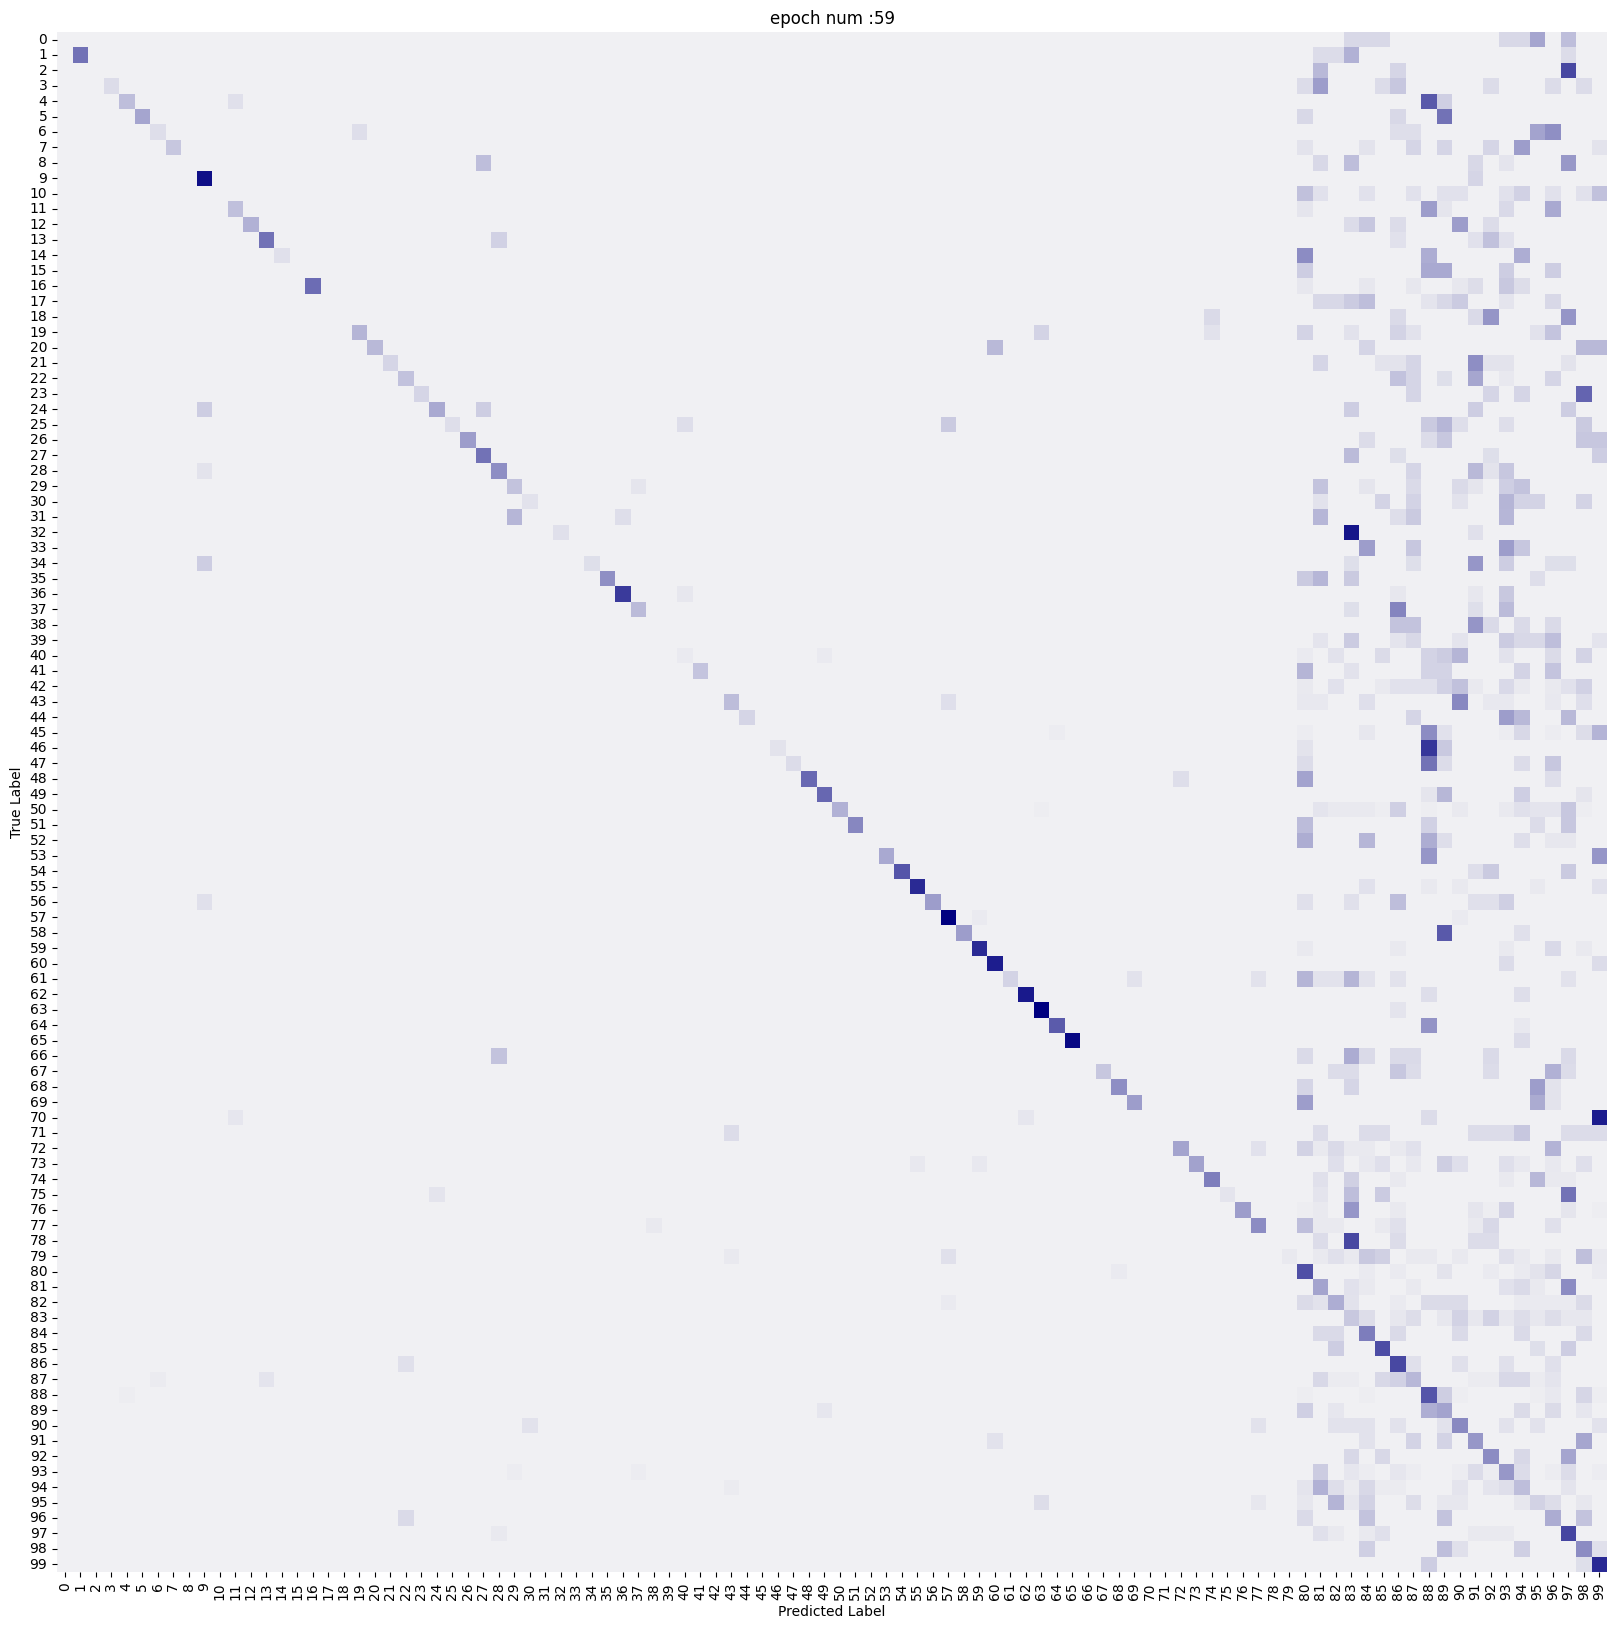

<Figure size 1400x600 with 0 Axes>

In [35]:
acc_history2_1, loss_history2_1 = evaluate_B_1()

## check network copy

In [19]:
# loading phase1 model
model1 = CNN(80)
model2 = CNN(100)
model1 = model1.to(device)
model2 = model2.to(device)
model_path = './CNN_model_ph1.pth'
model1.load_state_dict(torch.load(model_path))

# Copy parameters from model1 to model2 (excluding the fully connected layer)
for layer1, layer2 in zip(model1.children(), model2.children()):
    if isinstance(layer1, nn.Linear):
        continue  # Skip copying parameters for fully connected layer

    # Copy parameters from layer1 to layer2
    for param1, param2 in zip(layer1.parameters(), layer2.parameters()):
        param2.data.copy_(param1.data)

model2.fc.weight.data[:80, :] = model1.fc.weight.data
model2.fc.bias.data[:80] = model1.fc.bias.data
# model2.freeze_layers()

# -----------------
# Compare all layers except the fully connected layer
def are_layers_except_fc_equal(model1, model2):
    for layer1, layer2 in zip(model1.children(), model2.children()):
        if isinstance(layer1, nn.Linear):
            continue  # Skip the fully connected layer
        if not all(torch.equal(param1, param2) for param1, param2 in zip(layer1.parameters(), layer2.parameters())):
            return False
    return True

# Check if all layers except the fully connected layer are equal
layers_except_fc_equal = are_layers_except_fc_equal(model1, model2)
print(f"Are all layers except the fully connected layer equal? {layers_except_fc_equal}")

# -----------------
# Count the number of equal parameters
equal_parameters_count = 0
total_parameters_count = 0

for param1, param2 in zip(model1.fc.weight.data, model2.fc.weight.data):
    total_parameters_count += param1.numel()

    # Check if parameters are equal
    if torch.equal(param1, param2):
        equal_parameters_count += param1.numel()

# Calculate the percentage of equal parameters
percentage_equal_parameters = (equal_parameters_count / total_parameters_count) * 100

print(f"Number of equal parameters in the fully connected layer: {equal_parameters_count}")
print(f"Total number of parameters in the fully connected layer: {total_parameters_count}")
print(f"Percentage of equal parameters: {percentage_equal_parameters:.2f}%")

Are all layers except the fully connected layer equal? True
Number of equal parameters in the fully connected layer: 327680
Total number of parameters in the fully connected layer: 327680
Percentage of equal parameters: 100.00%


## part2 - evaluate on B dataset

In [20]:
def evaluate_B_2():
    num_epochs = 60
    learning_rate = 0.0003

    full_dataloaders = {
        'train': B_train_dl,
        'test': test_all
    }

    # loading phase1 model
    model1 = CNN(80)
    model2 = CNN(100)
    model1 = model1.to(device)
    model2 = model2.to(device)
    model_path = './CNN_model_ph1.pth'
    model1.load_state_dict(torch.load(model_path))

    # Copy parameters from model1 to model2 (excluding the fully connected layer)
    for layer1, layer2 in zip(model1.children(), model2.children()):
        if isinstance(layer1, nn.Linear):
            continue  # Skip copying parameters for fully connected layer

        # Copy parameters from layer1 to layer2
        for param1, param2 in zip(layer1.parameters(), layer2.parameters()):
            param2.data.copy_(param1.data)

    model2.fc.weight.data[:80, :] = model1.fc.weight.data
    model2.fc.bias.data[:80] = model1.fc.bias.data

    # freeze all the layers exept fully connected layer
    model2.freeze_except_FC_layer()

    optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9)
    cross_entropy = nn.CrossEntropyLoss()

    acc_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}

    for epoch in range(num_epochs):
        train_acc, train_loss = train_one_epoch(model=model2, optim=optimizer, dataloader=full_dataloaders['train'], loss_fn=cross_entropy)
        test_acc, test_loss = test_model(model=model2, dataloader=full_dataloaders['test'], loss_fn=cross_entropy)

        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        loss_history['train'].append(train_loss)
        loss_history['test'].append(test_loss)

        print(f"---------< epoch: {epoch} >---------")

    # # save model
    model_path = './CNN_model_ph2_2.pth'
    torch.save(model2.state_dict(), model_path)

    # plot accuracy and loss
    custom_plot_training_stats(acc_history, loss_history, ['train', 'test'], title='demp', dir='demo_plots_2_2')

    # show the details of model
    batch_size=250
    print(summary(model2, input_size=(batch_size, 3, 64, 64)))

    return (acc_history, loss_history)

In [21]:
acc_history2_2, loss_history2_2 = evaluate_B_2()

train:  tensor(0) 100
test:  tensor(27) 2056
---------< epoch: 0 >---------
train:  tensor(0) 100
test:  tensor(24) 2056
---------< epoch: 1 >---------
train:  tensor(0) 100
test:  tensor(30) 2056
---------< epoch: 2 >---------
train:  tensor(0) 100
test:  tensor(36) 2056
---------< epoch: 3 >---------
train:  tensor(0) 100
test:  tensor(37) 2056
---------< epoch: 4 >---------
train:  tensor(0) 100
test:  tensor(39) 2056
---------< epoch: 5 >---------
train:  tensor(0) 100
test:  tensor(39) 2056
---------< epoch: 6 >---------
train:  tensor(0) 100
test:  tensor(41) 2056
---------< epoch: 7 >---------
train:  tensor(0) 100
test:  tensor(42) 2056
---------< epoch: 8 >---------
train:  tensor(0) 100
test:  tensor(45) 2056
---------< epoch: 9 >---------
train:  tensor(0) 100
test:  tensor(45) 2056
---------< epoch: 10 >---------
train:  tensor(0) 100
test:  tensor(52) 2056
---------< epoch: 11 >---------
train:  tensor(0) 100
test:  tensor(54) 2056
---------< epoch: 12 >---------
train:  t

<Figure size 1400x600 with 0 Axes>

## part3 - evaluate on B dataset

In [22]:
def evaluate_B_3():
    num_epochs = 60
    learning_rate = 0.0003

    full_dataloaders = {
        'train': B_train_dl,
        'test': test_all
    }

    # loading phase1 model
    model1 = CNN(80)
    model2 = CNN(100)
    model1 = model1.to(device)
    model2 = model2.to(device)
    model_path = './CNN_model_ph1.pth'
    model1.load_state_dict(torch.load(model_path))

    # Copy parameters from model1 to model2 (excluding the fully connected layer)
    for layer1, layer2 in zip(model1.children(), model2.children()):
        if isinstance(layer1, nn.Linear):
            continue  # Skip copying parameters for fully connected layer

        # Copy parameters from layer1 to layer2
        for param1, param2 in zip(layer1.parameters(), layer2.parameters()):
            param2.data.copy_(param1.data)

    model2.fc.weight.data[:80, :] = model1.fc.weight.data
    model2.fc.bias.data[:80] = model1.fc.bias.data

    # freeze all the layers exept last 20 neurons of fully connected layer
    model2.freeze_except_FC_layer()
    model2.freeze_FC_except_last_20_neurons()

    optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9)
    cross_entropy = nn.CrossEntropyLoss()

    acc_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}

    for epoch in range(num_epochs):
        train_acc, train_loss = train_one_epoch(model=model2, optim=optimizer, dataloader=full_dataloaders['train'], loss_fn=cross_entropy)
        test_acc, test_loss = test_model(model=model2, dataloader=full_dataloaders['test'], loss_fn=cross_entropy)

        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        loss_history['train'].append(train_loss)
        loss_history['test'].append(test_loss)

        print(f"---------< epoch: {epoch} >---------")

    # # save model
    model_path = './CNN_model_ph2_3.pth'
    torch.save(model2.state_dict(), model_path)

    # plot accuracy and loss
    custom_plot_training_stats(acc_history, loss_history, ['train', 'test'], title='demp', dir='demo_plots_2_3')

    # show the details of model
    batch_size=250
    print(summary(model2, input_size=(batch_size, 3, 64, 64)))

    return (acc_history, loss_history)

In [23]:
acc_history2_2, loss_history2_2 = evaluate_B_3()

train:  tensor(0) 100
test:  tensor(27) 2056
---------< epoch: 0 >---------
train:  tensor(0) 100
test:  tensor(24) 2056
---------< epoch: 1 >---------
train:  tensor(0) 100
test:  tensor(30) 2056
---------< epoch: 2 >---------
train:  tensor(0) 100
test:  tensor(36) 2056
---------< epoch: 3 >---------
train:  tensor(0) 100
test:  tensor(38) 2056
---------< epoch: 4 >---------
train:  tensor(0) 100
test:  tensor(39) 2056
---------< epoch: 5 >---------
train:  tensor(0) 100
test:  tensor(40) 2056
---------< epoch: 6 >---------
train:  tensor(0) 100
test:  tensor(41) 2056
---------< epoch: 7 >---------
train:  tensor(0) 100
test:  tensor(44) 2056
---------< epoch: 8 >---------
train:  tensor(0) 100
test:  tensor(46) 2056
---------< epoch: 9 >---------
train:  tensor(0) 100
test:  tensor(46) 2056
---------< epoch: 10 >---------
train:  tensor(0) 100
test:  tensor(52) 2056
---------< epoch: 11 >---------
train:  tensor(0) 100
test:  tensor(54) 2056
---------< epoch: 12 >---------
train:  t

KeyboardInterrupt: 